# **Quora Insincere Questions Classification**
- Detect toxic content to improve online conversations

An existential problem for any major website today is **how to handle toxic and divisive content.** Quora wants to tackle this problem head-on to keep their platform a place where users can feel safe sharing their knowledge with the world.

**Quora** is a platform that empowers people to learn from each other. On Quora, people can ask questions and connect with others who contribute unique insights and quality answers. A key challenge is to weed out insincere questions -- those founded upon false premises, or that intend to make a statement rather than look for helpful answers.

***In this competition you will be predicting whether a question asked on Quora is sincere or not.***



An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

- Has a non-neutral tone
  - Has an exaggerated tone to underscore a point about a group of people.
  - Is rhetorical and meant to imply a statement about a group of people
- Is disparaging or inflammatory.
  - Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype.
  - Makes disparaging attacks/insults against a specific person or group of people.
  - Based on an outlandish premise about a group of people.
  - Disparages against a characteristic that is not fixable and not measurable.
- Isn't grounded in reality.
  - Based on false information, or contains absurd assumptions.
- Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers.

### **Data Overview**
We are not allowed to use any external data sources. As a result we can use only train and test datasets as well as embeddings which were provided by organizers.

- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - A sample submission in the correct format.
- enbeddings/ - Folder containing word embeddings.

The following embeddings are given to us which can be used for building our models.

### **Embeddings**

- **GoogleNews-vectors-negative300** - https://code.google.com/archive/p/word2vec/
- **glove.840B.300d** - https://nlp.stanford.edu/projects/glove/
- **paragram_300_sl999** - https://cogcomp.org/page/resource_view/106
- **wiki-news-300d-1M** - https://fasttext.cc/docs/en/english-vectors.html

### **Import Packages**

In [0]:
import pandas as pd
import numpy as np
import string

# Configure visualisations
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

# Configure seaborn
sns.set_style('white')
sns.set_style('white',{"xtick.major.size": 5, "ytick.major.size": 5})

plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 15

from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

In [0]:
# Text Annotation
def text_annotate(cnt):
    for i in cnt.patches:
        height = i.get_height()
        cnt.text(i.get_x() + i.get_width()/2., height,'%d' % int(height),ha='center',va='bottom')

def ngram_extractor(text, n_gram):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

# Function to generate a dataframe with n_gram and top max_row frequencies
def generate_ngrams(df, col, n_gram, max_row):
    temp_dict = defaultdict(int)
    for question in df[col]:
        for word in ngram_extractor(question, n_gram):
            temp_dict[word] += 1
    temp_df = pd.DataFrame(sorted(temp_dict.items(), key=lambda x: x[1])[::-1]).head(max_row)
    temp_df.columns = ["word", "wordcount"]
    return temp_df

def comparison_plot(df_1,df_2,col_1,col_2, space):
    fig, ax = plt.subplots(1, 2, figsize=(15,12))
    
    sns.barplot(x=col_2, y=col_1, data=df_1, ax=ax[0], color="palegreen")
    sns.barplot(x=col_2, y=col_1, data=df_2, ax=ax[1], color="palegreen")

    ax[0].set_xlabel('Word count', size=14, color="green")
    ax[0].set_ylabel('Words', size=14, color="green")
    ax[0].set_title('Top words in sincere questions', size=18, color="green")

    ax[1].set_xlabel('Word count', size=14, color="green")
    ax[1].set_ylabel('Words', size=14, color="green")
    ax[1].set_title('Top words in insincere questions', size=18, color="green")

    fig.subplots_adjust(wspace=space)
    
    plt.show()

### **Load dataset**

In [3]:
train = pd.read_csv("/content/train.csv.zip")
test = pd.read_csv("/content/test.csv.zip")

print('Train data: \nRows: {}\nCols: {}'.format(train.shape[0],train.shape[1]))
print(train.columns)

print('\nTest data: \nRows: {}\nCols: {}'.format(test.shape[0],test.shape[1]))
print(test.columns)

Train data: 
Rows: 1306122
Cols: 3
Index(['qid', 'question_text', 'target'], dtype='object')

Test data: 
Rows: 375806
Cols: 2
Index(['qid', 'question_text'], dtype='object')


### **Exploratory Data Analysis**

In [4]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


There are no missing values

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
qid              1306122 non-null object
question_text    1306122 non-null object
target           1306122 non-null int64
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


### **Meta Features**

Now let us create some meta features and then look at how they are distributed between the classes. 

In [0]:
# Number of words in the questions
train["word_count"] = train["question_text"].apply(lambda x: len(str(x).split()))
# Number of characters in the questions
train["char_length"] = train["question_text"].apply(lambda x: len(str(x)))
# Number of unique words in the questions
train["unique_word_count"] = train["question_text"].apply(lambda x: len(set(str(x).split())))
# Number of stop words in the questions
train["stop_words_count"] = train["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
# Number of punctuations in the questions
train["punc_count"] = train["question_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
# Number of upper case words in the questions
train["upper_words"] = train["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

- Insincere questions have more number of words as well as characters compared to sincere questions. So this might be a useful feature in our model.

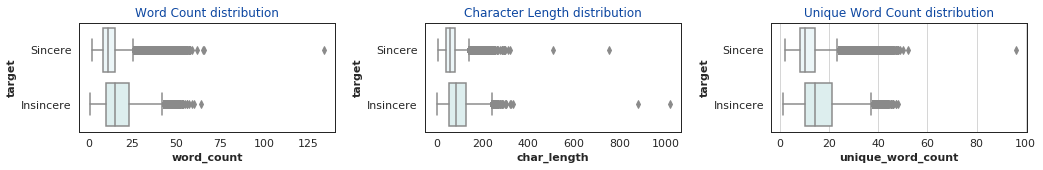

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(17,2))
labels = ['Sincere', 'Insincere']
sns.boxplot(x="word_count", y="target", data=train, palette=sns.color_palette("BuGn", 10), orient='h', ax=axes[0])
axes[0].set_title('Word Count distribution', size=12, color="#0D47A1")
axes[0].set_yticklabels(labels)

sns.boxplot(x="char_length", y="target", data=train, palette=sns.color_palette("BuGn", 10), orient='h', ax=axes[1])
axes[1].set_title('Character Length distribution', size=12, color="#0D47A1")
axes[1].set_yticklabels(labels)

sns.boxplot(x="unique_word_count", y="target", data=train,palette=sns.color_palette("BuGn", 10), orient='h',ax=axes[2])
axes[2].set_title('Unique Word Count distribution', size=12, color="#0D47A1")
axes[2].set_yticklabels(labels)

fig.subplots_adjust(wspace=0.35)
plt.gca().xaxis.grid(True)
plt.show()


- Insincere questions have more stop words than sincere questions.
- Insincere questions have more punctuations.
- More upper case words in Sincere questions.

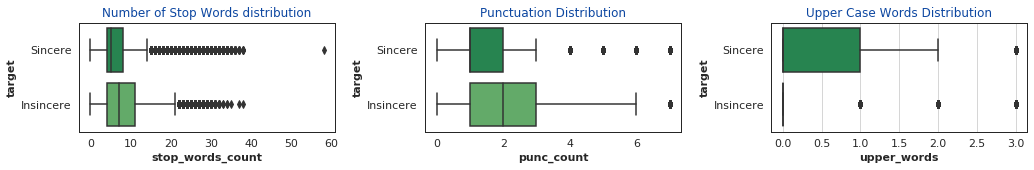

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(17,2))

sns.boxplot(x="stop_words_count", y="target", data=train,palette=sns.color_palette("RdYlGn_r", 10), orient='h',ax=axes[0])
axes[0].set_title('Number of Stop Words distribution', size=12, color="#0D47A1")
axes[0].set_yticklabels(labels)

sns.boxplot(x="punc_count", y="target", data=train[train['punc_count']<train['punc_count'].quantile(.99)], 
            palette=sns.color_palette("RdYlGn_r", 10), orient='h',ax=axes[1] )
axes[1].set_title('Punctuation Distribution', size=12, color="#0D47A1")
axes[1].set_yticklabels(labels)

sns.boxplot(x="upper_words", y="target", data=train[train['upper_words']<train['upper_words'].quantile(.99)], 
            palette=sns.color_palette("RdYlGn_r", 10), orient='h', ax=axes[2])
axes[2].set_title('Upper Case Words Distribution', size=12, color="#0D47A1")
axes[2].set_yticklabels(labels)

fig.subplots_adjust(wspace=0.35)
plt.gca().xaxis.grid(True)
plt.show()

In [9]:
print('---------------------------------Train set-----------------------------------')
print('Average word length of questions in train is {0:.0f}.'.format(np.mean(train['question_text'].apply(lambda x: len(x.split())))))
print('Max word length of questions in train is {0:.0f}.'.format(np.max(train['question_text'].apply(lambda x: len(x.split())))))
print('Average character length of questions in train is {0:.0f}.'.format(np.mean(train['question_text'].apply(lambda x: len(x)))))
print('---------------------------------Test set------------------------------------')
print('Average word length of questions in test is {0:.0f}.'.format(np.mean(test['question_text'].apply(lambda x: len(x.split())))))
print('Max word length of questions in test is {0:.0f}.'.format(np.max(test['question_text'].apply(lambda x: len(x.split())))))
print('Average character length of questions in test is {0:.0f}.'.format(np.mean(test['question_text'].apply(lambda x: len(x)))))

---------------------------------Train set-----------------------------------
Average word length of questions in train is 13.
Max word length of questions in train is 134.
Average character length of questions in train is 71.
---------------------------------Test set------------------------------------
Average word length of questions in test is 13.
Max word length of questions in test is 87.
Average character length of questions in test is 71.


As we can see on average questions in train and test datasets are similar, but there are quite long questions in train dataset.

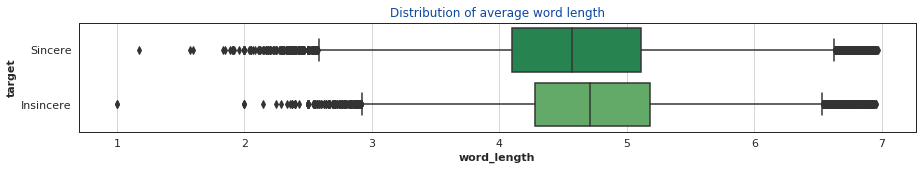

In [10]:
# Average/Mean word length in the questions
train["word_length"] = train["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

fig, ax = plt.subplots(figsize=(15,2))
sns.boxplot(x="word_length", y="target", data=train[train['word_length']<train['word_length'].quantile(.99)], 
            ax=ax, palette=sns.color_palette("RdYlGn_r", 10), orient='h')
ax.set_title('Distribution of average word length', size=12, color="#0D47A1")
ax.set_yticklabels(labels)
plt.gca().xaxis.grid(True)
plt.show()

In [0]:
from keras.preprocessing.text import Tokenizer
max_features = 120000
tk = Tokenizer(lower = True, filters='', num_words=max_features)
full_text = list(train['question_text'].values) + list(test['question_text'].values)
tk.fit_on_texts(full_text)

In [0]:
train_tokenized = tk.texts_to_sequences(train['question_text'].fillna('missing'))
test_tokenized = tk.texts_to_sequences(test['question_text'].fillna('missing'))

Text(0.5, 1.0, 'Distribution of question text length in characters')

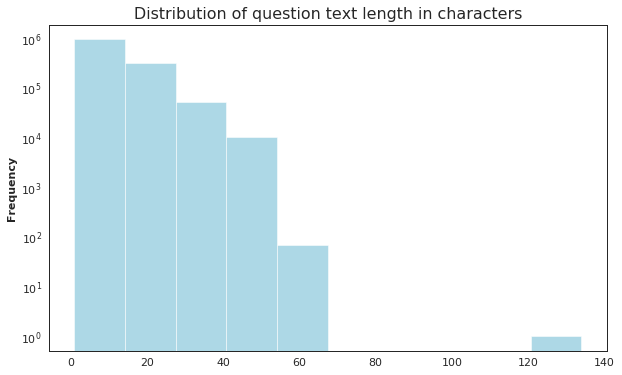

In [13]:
train['question_text'].apply(lambda x: len(x.split())).plot(kind='hist', color='lightblue')
plt.yscale('log')
plt.title('Distribution of question text length in characters')

We can see that most of the questions are 40 words long or shorter. Let's try having sequence length equal to 70 for now.

### **Target Distribution**

First let us look at the distribution of the target variable.

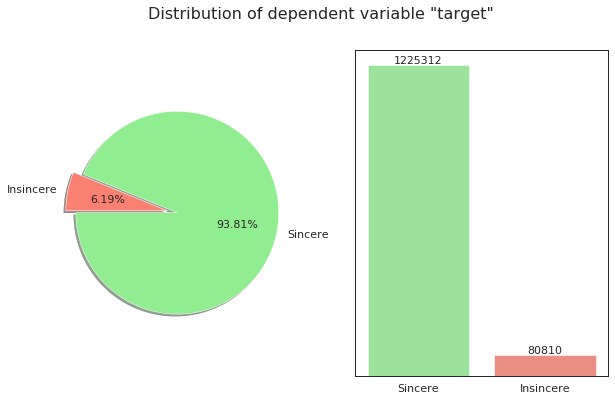

In [14]:
fig,axes=plt.subplots(1,2)
plt.suptitle('Distribution of dependent variable "target"',fontsize=16)

# Pie chart
train['target'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.2f%%', ax=axes[0],labels=labels,
                                        colors=['#90EE90','#FA8072'], shadow=True, startangle=180)

axes[0].set_ylabel('')

# Bar chart
cnt = sns.countplot('target', data=train, palette=['#90EE90', '#FA8072'], ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_yticklabels('')
axes[1].set_xticklabels(labels)
text_annotate(cnt)
plt.show()

So about **6%** of the training data are ***insincere questions*** (target=1) and rest of them are sincere.

There seem to be a variety of words in there. May be it is a good idea to look at the most frequent words in each of the classes separately.

**Word Frequency plot of sincere & insincere questions**

- Sincere questions are dominated by words like best, will, people, good, one, etc. with no reference to any specific nouns. Some of these words are high even in insincere words - meaning they are not significant to the classification.
- Insincere questions are dominated by words like trump, women, white, men, indian, muslims, black, americans, girls, indians, sex and india. More `reference to specific groups of people` of directly a person i.e. Donald Trump.

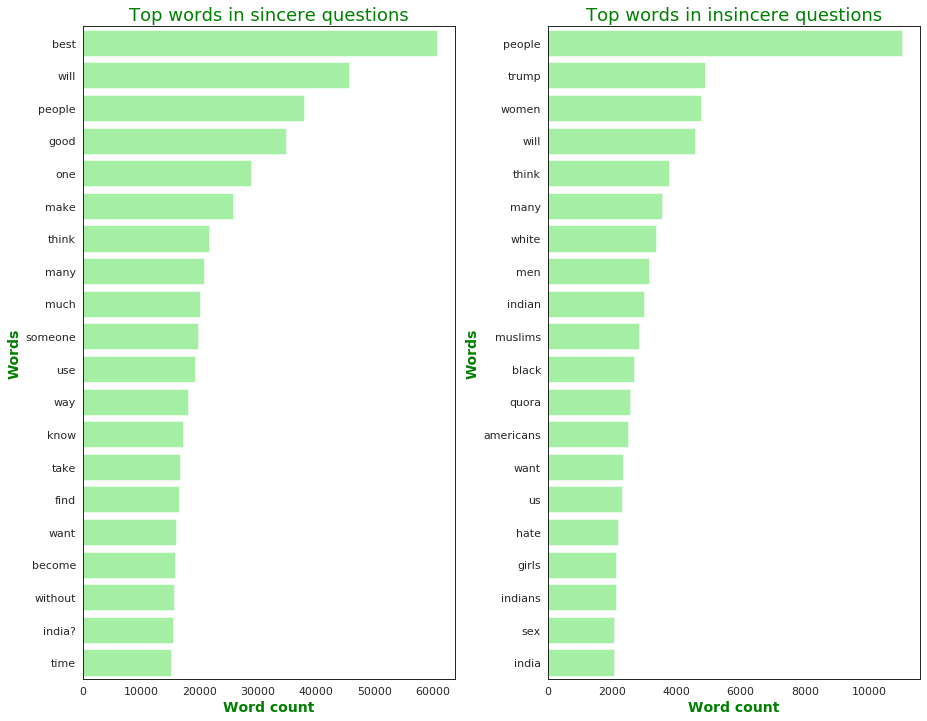

In [15]:
sincere_1gram = generate_ngrams(train[train["target"]==0], 'question_text', 1, 20)
insincere_1gram = generate_ngrams(train[train["target"]==1], 'question_text', 1, 20)

comparison_plot(sincere_1gram,insincere_1gram,'word','wordcount', 0.25)

**Top bi-grams words in sincere and insincere questions**

- Top 3 bigrams in the insincere questions are `'Donald Trump'`, `'White People'` and `'Black People'`. Questions related to race are highly insincere.
- Presence of `Chinese` people, `Indian muslims`, `Indian girls`, `North Indians`, Indian women and White Women confirm the same.
- Sincere questions have best way, year old, will happen, etc. as the top ones. No clear trend there but 'best' is the key word to look for.

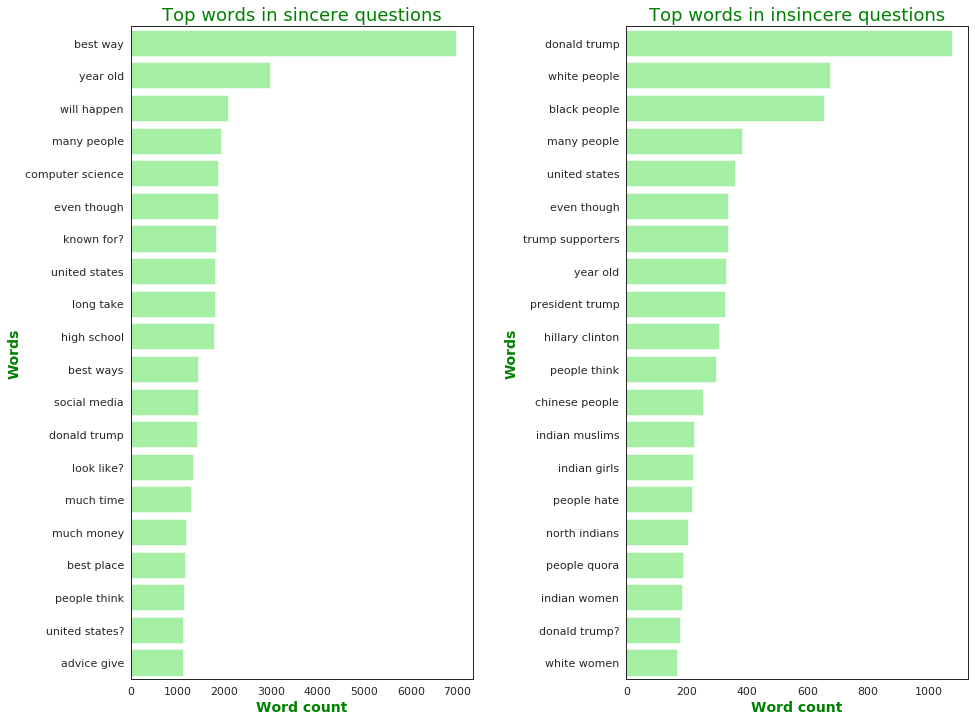

In [16]:
sincere_2gram = generate_ngrams(train[train["target"]==0], 'question_text', 2, 20)
insincere_2gram = generate_ngrams(train[train["target"]==1], 'question_text', 2, 20)

comparison_plot(sincere_2gram,insincere_2gram,'word','wordcount', .45)

**Top tri-grams words in sincere and insincere questions**

- Insincere questions are related to hypothetical scenarios, age, race, etc
- Sincere questions are related to tips, advices, suggestions, facts, etc.

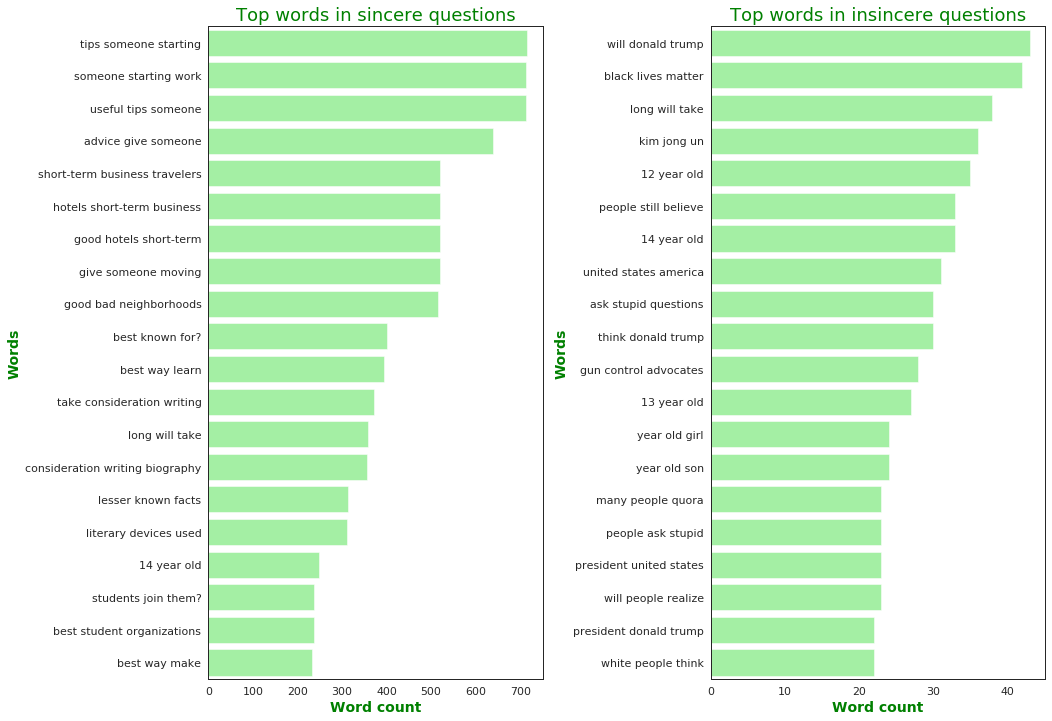

In [17]:
sincere_3gram = generate_ngrams(train[train["target"]==0], 'question_text', 3, 20)
insincere_3gram = generate_ngrams(train[train["target"]==1], 'question_text', 3, 20)

comparison_plot(sincere_3gram,insincere_3gram,'word','wordcount', .50)


A base model with vectorized matrix shows that insincere words are predominantly due to identification of religion, nationality, race, caste, political affiliation, etc.

To start with, let us just build a baseline model (Logistic Regression) with TFIDF vectors.

In [0]:
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [0]:
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit_transform(train['question_text'].values.tolist() + test['question_text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['question_text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['question_text'].values.tolist())

Let us build the model now.

In [20]:
train_y = train["target"].values

def runModel(train_X, train_y, test_X, test_y, test_X2):
    model = linear_model.LogisticRegression(C=5., solver='sag')
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)[:,1]
    pred_test_y2 = model.predict_proba(test_X2)[:,1]
    return pred_test_y, pred_test_y2, model

print("Building model.")
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0]])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runModel(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break


Building model.


Getting the best threshold based on validation sample.

In [21]:
for thresh in np.arange(0.1, 0.201, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_val_y>thresh).astype(int))))

F1 score at threshold 0.1 is 0.5686754495282179
F1 score at threshold 0.11 is 0.5766786085750607
F1 score at threshold 0.12 is 0.5837343484402308
F1 score at threshold 0.13 is 0.5897296495823655
F1 score at threshold 0.14 is 0.5931104614211262
F1 score at threshold 0.15 is 0.595752462056895
F1 score at threshold 0.16 is 0.596408595819841
F1 score at threshold 0.17 is 0.596942968279187
F1 score at threshold 0.18 is 0.5959782669579342
F1 score at threshold 0.19 is 0.5941465645364126
F1 score at threshold 0.2 is 0.5927026869499329


So we are getting a better F1 score for this model at 0.17.

Now let us look at the important words used for classifying the insincere questions. We will use **eli5** library

In [24]:
import eli5
eli5.show_weights(model, vec=tfidf_vec, top=100, feature_filter=lambda x: x != '<BIAS>')

Weight?,Feature
+19.704,castrated
+17.520,muslims
+17.263,democrats
+17.076,liberals
+16.708,castrate
+15.554,indians
+14.486,trump
+14.411,americans
+14.167,women
+14.088,blacks
